In [4]:
import os
import sys
sys.path.append('/workspace/sy/sungyun/mdpi_IDS')
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, f1_score
import sklearn.metrics
from Utils import PklsFolder, make_cls_idx, split_train_val_test
from Layers import Flow_CLF
from tqdm import tqdm
from pathlib import Path 
import sys

In [5]:
#parameters
batch_size = 32
num_epoch = 100

num_layers = 2 # Byte_EncoderLayer 개수
d_model = 40
num_heads = 4
d_k = 10
d_v = 10
d_hid = (d_model * 2) #PositionwiseFeedForward hidden dim
add_attn_dim = (d_model * 2) # PacketEncoder attn_dim
pck_len = 350
num_classes = 2
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model_dir = './model'

#validation


model_path_list = sorted([x for x in Path(model_dir).glob('*_epoch_*.pt')], key = lambda x : int(x.stem.strip('model_epoch_')))
loss_history_path = './val_loss_history.npy'


#test
#best_model_path = [sorted([x for x in Path(model_dir).glob('*_epoch_*.pt')], key = lambda x : int(x.stem.strip('model_epoch_')))[98]]


In [7]:
flow_dataset = PklsFolder('../../../pkls')  # ISCX 2012 Dataset 

#validation
"""
val_set_idx = np.load('val_set_idx.npy')
val_random_sampler = torch.utils.data.SubsetRandomSampler(val_set_idx)
val_dataloader = DataLoader(flow_dataset, batch_size = batch_size, shuffle = False,  sampler = val_random_sampler)
"""
#test
test_set_idx = np.load('test_set_idx_ISCX2012.npy')
test_random_sampler = torch.utils.data.SubsetRandomSampler(test_set_idx)
test_dataloader = DataLoader(flow_dataset, batch_size = batch_size, shuffle = False,  sampler = test_random_sampler)

loss_history = []

In [5]:
#validation
for model_path in tqdm(model_path_list) :
    hit = 0
    all_preds = []
    all_labels = []
    score = []
    
    model =  Flow_CLF(num_layers, d_model,num_heads, d_k, d_v, d_hid, add_attn_dim, pck_len, device, num_classes = num_classes, dropout = dropout).to(device)
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path)['state'])
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    
    with torch.no_grad():
        val_loss = 0
        for (val_x, val_y) in val_dataloader:
            preds = model(val_x.type(torch.long).to(device))
            score.append(preds[:,1])
            loss = criterion(preds, val_y.type(torch.long).to(device))
            val_loss += loss.item()
            hit += ((preds.argmax(dim=1) == val_y.type(torch.long).to(device)).sum().item())

            all_preds.append(preds.argmax(dim=1))
            all_labels.append(val_y)

    loss_history.append(val_loss)
    accuracy = 100 * (hit/len(val_random_sampler))
    print(f'accuracy : {accuracy:.4f}')
    print(f'val loss : {val_loss}')

    del model

np.save(loss_history_path, np.array(loss_history))

  0%|          | 0/100 [00:00<?, ?it/s]/workspace/sy/sungyun/mdpi_IDS/Layers.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_score = self.softmax(attn2).unsqueeze(-1)
  1%|          | 1/100 [02:11<3:36:47, 131.39s/it]

accuracy : 82.0700
val loss : 397.13458816707134


  2%|▏         | 2/100 [03:54<3:20:45, 122.91s/it]

accuracy : 86.9500
val loss : 356.62565529346466


  3%|▎         | 3/100 [05:37<3:09:01, 116.92s/it]

accuracy : 87.4533
val loss : 338.65342539548874


  4%|▍         | 4/100 [07:21<3:00:44, 112.96s/it]

accuracy : 87.7833
val loss : 313.24779499322176


  5%|▌         | 5/100 [09:03<2:54:00, 109.90s/it]

accuracy : 88.1900
val loss : 307.4478141963482


  6%|▌         | 6/100 [10:47<2:49:04, 107.92s/it]

accuracy : 88.2667
val loss : 289.1979764252901


  7%|▋         | 7/100 [12:29<2:44:32, 106.15s/it]

accuracy : 88.2733
val loss : 289.6493423432112


  8%|▊         | 8/100 [14:12<2:41:17, 105.19s/it]

accuracy : 88.3000
val loss : 288.6561939045787


  9%|▉         | 9/100 [15:54<2:38:06, 104.25s/it]

accuracy : 88.3133
val loss : 282.8870660662651


 10%|█         | 10/100 [17:37<2:36:04, 104.04s/it]

accuracy : 94.5467
val loss : 160.63854432851076


 11%|█         | 11/100 [19:20<2:33:41, 103.61s/it]

accuracy : 96.0700
val loss : 88.78797313477844


 12%|█▏        | 12/100 [21:03<2:31:52, 103.55s/it]

accuracy : 98.1533
val loss : 60.759449574165046


 13%|█▎        | 13/100 [22:47<2:30:10, 103.56s/it]

accuracy : 97.1400
val loss : 72.69125951454043


 14%|█▍        | 14/100 [24:31<2:28:35, 103.67s/it]

accuracy : 98.2267
val loss : 52.93657238781452


 15%|█▌        | 15/100 [26:14<2:26:38, 103.51s/it]

accuracy : 98.0067
val loss : 54.76200330629945


 16%|█▌        | 16/100 [27:57<2:24:48, 103.43s/it]

accuracy : 98.4067
val loss : 57.40816249139607


 17%|█▋        | 17/100 [29:40<2:22:53, 103.30s/it]

accuracy : 98.4467
val loss : 48.54344381019473


 18%|█▊        | 18/100 [31:24<2:21:14, 103.35s/it]

accuracy : 98.5733
val loss : 44.790766580961645


 19%|█▉        | 19/100 [33:07<2:19:25, 103.28s/it]

accuracy : 98.5633
val loss : 45.58318459242582


 20%|██        | 20/100 [34:50<2:17:45, 103.32s/it]

accuracy : 98.7433
val loss : 42.34756092913449


 21%|██        | 21/100 [36:35<2:16:39, 103.79s/it]

accuracy : 98.2500
val loss : 48.4581257076934


 22%|██▏       | 22/100 [38:19<2:14:47, 103.68s/it]

accuracy : 98.7767
val loss : 41.395168740767986


 23%|██▎       | 23/100 [40:03<2:13:21, 103.91s/it]

accuracy : 98.2733
val loss : 49.61732334084809


 24%|██▍       | 24/100 [41:47<2:11:35, 103.89s/it]

accuracy : 98.1800
val loss : 44.94999009184539


 25%|██▌       | 25/100 [43:29<2:09:23, 103.52s/it]

accuracy : 98.5867
val loss : 43.12862701434642


 26%|██▌       | 26/100 [45:13<2:07:40, 103.53s/it]

accuracy : 98.0900
val loss : 46.64831390278414


 27%|██▋       | 27/100 [46:55<2:05:25, 103.10s/it]

accuracy : 98.1400
val loss : 47.44363521784544


 28%|██▊       | 28/100 [48:40<2:04:15, 103.55s/it]

accuracy : 98.5233
val loss : 42.17812281567603


 29%|██▉       | 29/100 [50:23<2:02:33, 103.57s/it]

accuracy : 98.4267
val loss : 47.35699703823775


 30%|███       | 30/100 [52:08<2:01:10, 103.87s/it]

accuracy : 98.1900
val loss : 49.466214863583446


 31%|███       | 31/100 [53:51<1:59:18, 103.75s/it]

accuracy : 98.4000
val loss : 41.52609503734857


 32%|███▏      | 32/100 [55:35<1:57:35, 103.76s/it]

accuracy : 98.1700
val loss : 45.1818328499794


 33%|███▎      | 33/100 [57:21<1:56:43, 104.53s/it]

accuracy : 98.3500
val loss : 40.57852872600779


 34%|███▍      | 34/100 [59:09<1:55:57, 105.42s/it]

accuracy : 98.6800
val loss : 40.61329095065594


 35%|███▌      | 35/100 [1:00:59<1:55:35, 106.69s/it]

accuracy : 98.6467
val loss : 38.003564081620425


 36%|███▌      | 36/100 [1:02:50<1:55:15, 108.05s/it]

accuracy : 98.1767
val loss : 48.38674447592348


 37%|███▋      | 37/100 [1:04:34<1:52:18, 106.96s/it]

accuracy : 98.2233
val loss : 42.679024156183004


 38%|███▊      | 38/100 [1:06:21<1:50:26, 106.88s/it]

accuracy : 98.1767
val loss : 42.204510796349496


 39%|███▉      | 39/100 [1:08:08<1:48:41, 106.92s/it]

accuracy : 98.2267
val loss : 41.43788645230234


 40%|████      | 40/100 [1:09:56<1:47:08, 107.14s/it]

accuracy : 98.3200
val loss : 40.682508539408445


 41%|████      | 41/100 [1:11:42<1:45:04, 106.85s/it]

accuracy : 98.3367
val loss : 44.17945122811943


 42%|████▏     | 42/100 [1:13:27<1:42:50, 106.39s/it]

accuracy : 98.2000
val loss : 44.67189976852387


 43%|████▎     | 43/100 [1:15:12<1:40:45, 106.06s/it]

accuracy : 98.5067
val loss : 37.82420130958781


 44%|████▍     | 44/100 [1:16:58<1:38:46, 105.84s/it]

accuracy : 98.3467
val loss : 42.881411149166524


 45%|████▌     | 45/100 [1:18:42<1:36:43, 105.52s/it]

accuracy : 98.3233
val loss : 51.75494031049311


 46%|████▌     | 46/100 [1:20:27<1:34:41, 105.21s/it]

accuracy : 98.4767
val loss : 42.08305834187195


 47%|████▋     | 47/100 [1:22:13<1:33:02, 105.33s/it]

accuracy : 98.7167
val loss : 39.10834505409002


 48%|████▊     | 48/100 [1:23:57<1:31:06, 105.12s/it]

accuracy : 98.7900
val loss : 52.04093592148274


 49%|████▉     | 49/100 [1:25:41<1:29:02, 104.76s/it]

accuracy : 98.7767
val loss : 44.14232518244535


 50%|█████     | 50/100 [1:27:27<1:27:35, 105.12s/it]

accuracy : 98.1900
val loss : 41.43240209668875


 51%|█████     | 51/100 [1:29:12<1:25:46, 105.03s/it]

accuracy : 98.4833
val loss : 44.68843931611627


 52%|█████▏    | 52/100 [1:30:58<1:24:09, 105.20s/it]

accuracy : 98.4900
val loss : 38.20831476151943


 53%|█████▎    | 53/100 [1:32:42<1:22:15, 105.01s/it]

accuracy : 98.7867
val loss : 35.65057023614645


 54%|█████▍    | 54/100 [1:34:27<1:20:34, 105.11s/it]

accuracy : 98.2733
val loss : 42.35648657288402


 55%|█████▌    | 55/100 [1:36:12<1:18:44, 105.00s/it]

accuracy : 97.2833
val loss : 88.43573012202978


 56%|█████▌    | 56/100 [1:37:57<1:16:58, 104.96s/it]

accuracy : 98.6667
val loss : 36.1395080499351


 57%|█████▋    | 57/100 [1:39:42<1:15:14, 105.00s/it]

accuracy : 98.2900
val loss : 37.64535668771714


 58%|█████▊    | 58/100 [1:41:29<1:13:53, 105.55s/it]

accuracy : 98.5600
val loss : 37.298316549509764


 59%|█████▉    | 59/100 [1:43:13<1:11:49, 105.10s/it]

accuracy : 98.6767
val loss : 38.719199690036476


 60%|██████    | 60/100 [1:44:59<1:10:16, 105.42s/it]

accuracy : 98.6433
val loss : 38.21066554170102


 61%|██████    | 61/100 [1:46:44<1:08:24, 105.24s/it]

accuracy : 98.9900
val loss : 36.7129494426772


 62%|██████▏   | 62/100 [1:48:28<1:06:25, 104.88s/it]

accuracy : 98.5900
val loss : 35.031559775583446


 63%|██████▎   | 63/100 [1:50:11<1:04:23, 104.43s/it]

accuracy : 98.4300
val loss : 38.05087057314813


 64%|██████▍   | 64/100 [1:51:55<1:02:33, 104.26s/it]

accuracy : 98.3067
val loss : 38.22266471479088


 65%|██████▌   | 65/100 [1:53:39<1:00:39, 103.97s/it]

accuracy : 98.7867
val loss : 35.82705962564796


 66%|██████▌   | 66/100 [1:55:24<59:11, 104.45s/it]  

accuracy : 98.4200
val loss : 46.09431178867817


 67%|██████▋   | 67/100 [1:57:08<57:23, 104.35s/it]

accuracy : 98.5100
val loss : 41.9339793715626


 68%|██████▊   | 68/100 [1:58:53<55:47, 104.60s/it]

accuracy : 97.2567
val loss : 88.68603751529008


 69%|██████▉   | 69/100 [2:00:38<53:58, 104.48s/it]

accuracy : 96.2367
val loss : 102.73121915850788


 70%|███████   | 70/100 [2:02:22<52:15, 104.51s/it]

accuracy : 98.5600
val loss : 34.80709124635905


 71%|███████   | 71/100 [2:04:06<50:28, 104.41s/it]

accuracy : 98.5433
val loss : 35.91549231670797


 72%|███████▏  | 72/100 [2:05:51<48:45, 104.48s/it]

accuracy : 98.4600
val loss : 34.01905637932941


 73%|███████▎  | 73/100 [2:07:34<46:51, 104.12s/it]

accuracy : 98.3167
val loss : 57.42697389423847


 74%|███████▍  | 74/100 [2:09:18<45:04, 104.02s/it]

accuracy : 98.6600
val loss : 33.401618958450854


 75%|███████▌  | 75/100 [2:11:01<43:15, 103.81s/it]

accuracy : 98.5533
val loss : 34.33940641209483


 76%|███████▌  | 76/100 [2:12:44<41:26, 103.58s/it]

accuracy : 98.3000
val loss : 47.27956095337868


 77%|███████▋  | 77/100 [2:14:28<39:43, 103.62s/it]

accuracy : 98.4867
val loss : 37.928121213801205


 78%|███████▊  | 78/100 [2:16:12<38:02, 103.77s/it]

accuracy : 98.8233
val loss : 28.689885078929365


 79%|███████▉  | 79/100 [2:17:56<36:17, 103.68s/it]

accuracy : 98.7433
val loss : 29.62063353601843


 80%|████████  | 80/100 [2:19:41<34:41, 104.07s/it]

accuracy : 98.7367
val loss : 34.33653135411441


 81%|████████  | 81/100 [2:21:26<33:03, 104.42s/it]

accuracy : 98.6000
val loss : 33.37117433920503


 82%|████████▏ | 82/100 [2:23:13<31:31, 105.06s/it]

accuracy : 98.6800
val loss : 29.60936923418194


 83%|████████▎ | 83/100 [2:24:58<29:49, 105.27s/it]

accuracy : 98.6800
val loss : 27.15055782487616


 84%|████████▍ | 84/100 [2:26:45<28:12, 105.79s/it]

accuracy : 98.6933
val loss : 27.351095619611442


 85%|████████▌ | 85/100 [2:28:32<26:30, 106.03s/it]

accuracy : 98.4700
val loss : 33.92884732596576


 86%|████████▌ | 86/100 [2:30:19<24:50, 106.44s/it]

accuracy : 98.4767
val loss : 31.42151799146086


 87%|████████▋ | 87/100 [2:32:06<23:04, 106.46s/it]

accuracy : 98.7000
val loss : 32.44578791037202


 88%|████████▊ | 88/100 [2:33:52<21:18, 106.52s/it]

accuracy : 98.4500
val loss : 34.0088262045756


 89%|████████▉ | 89/100 [2:35:39<19:33, 106.65s/it]

accuracy : 98.8267
val loss : 27.359494659118354


 90%|█████████ | 90/100 [2:37:26<17:47, 106.74s/it]

accuracy : 98.6267
val loss : 28.144903891254216


 91%|█████████ | 91/100 [2:39:13<16:00, 106.72s/it]

accuracy : 99.2167
val loss : 24.58671758323908


 92%|█████████▏| 92/100 [2:41:00<14:15, 106.89s/it]

accuracy : 98.9533
val loss : 25.242359967902303


 93%|█████████▎| 93/100 [2:42:46<12:25, 106.50s/it]

accuracy : 98.9967
val loss : 24.78132132999599


 94%|█████████▍| 94/100 [2:44:33<10:39, 106.56s/it]

accuracy : 99.1033
val loss : 24.173662342131138


 95%|█████████▌| 95/100 [2:46:19<08:52, 106.56s/it]

accuracy : 99.2167
val loss : 23.122471961658448


 96%|█████████▌| 96/100 [2:48:05<07:05, 106.34s/it]

accuracy : 98.8733
val loss : 25.495461554266512


 97%|█████████▋| 97/100 [2:49:49<05:16, 105.51s/it]

accuracy : 99.1233
val loss : 24.011727987322956


 98%|█████████▊| 98/100 [2:51:35<03:31, 105.68s/it]

accuracy : 99.0933
val loss : 24.793756316881627


 99%|█████████▉| 99/100 [2:53:21<01:45, 105.79s/it]

accuracy : 99.2133
val loss : 22.951204923912883


100%|██████████| 100/100 [2:55:08<00:00, 105.08s/it]

accuracy : 98.8900
val loss : 26.069436539895833


In [8]:
validation_loss = np.load('val_loss_history_ISCX2012.npy')

In [9]:
best_model_loss = sys.float_info.max

for i in range(len(validation_loss)):
    if validation_loss[i] < best_model_loss:
        best_model_loss = validation_loss[i]
        best_model_idx = i

In [10]:
best_model_idx

98

In [11]:
best_model_loss

22.951204923912883

In [12]:
from matplotlib import pyplot as plt

In [22]:
training_loss = torch.load(model_path_list[-1])['loss_history']
avg_training_loss = []

for i in range(len(training_loss)):
    avg_training_loss.append(training_loss[i]/50000)

In [23]:
validation_loss = np.load('./val_loss_history_ISCX2012.npy')
avg_validation_loss = []

for i in range(len(validation_loss)):
    avg_validation_loss.append(validation_loss[i]/ 30000)

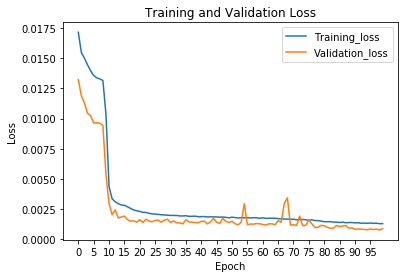

In [24]:
plt.plot([i for i in range(100)],avg_training_loss)
plt.plot([i for i in range(100)],avg_validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([i for i in range(0,100,5)])
plt.title('Training and Validation Loss')
plt.legend(['Training_loss','Validation_loss'])

In [28]:
#test
for model_path in [model_path_list[best_model_idx]] :
    hit = 0
    all_preds = []
    all_labels = []
    score = []
    
    model =  Flow_CLF(num_layers, d_model,num_heads, d_k, d_v, d_hid, add_attn_dim, pck_len, device, num_classes = num_classes, dropout = dropout).to(device)
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path)['state'])
    criterion = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for (test_x, test_y) in tqdm(test_dataloader):
            preds = model(test_x.type(torch.long).to(device))
            score.append(preds[:,1])
            loss = criterion(preds, test_y.type(torch.long).to(device))
            test_loss += loss.item()
            hit += ((preds.argmax(dim=1) == test_y.type(torch.long).to(device)).sum().item())

            all_preds.append(preds.argmax(dim=1))
            all_labels.append(test_y)

    loss_history.append(test_loss)
    accuracy = 100 * (hit/len(test_random_sampler))
    print(f'accuracy : {accuracy:.4f}')
    confusion_matrix = sklearn.metrics.confusion_matrix(torch.cat(all_labels).to('cpu'),torch.cat(all_preds).to('cpu')).ravel()
    #print(f'tn : {tn}, fp : {fp}, fn : {fp}, tp : {tp}')
    res_f1_score = f1_score(torch.cat(all_labels).to('cpu'),torch.cat(all_preds).to('cpu'))
    print(f'f1 score : {res_f1_score}')
    fpr, tpr, thresholds = roc_curve(torch.cat(all_labels).to('cpu'),torch.cat(all_preds).to('cpu'))
    print(f'fpr : {fpr}, tpr : {tpr}, threshold : {thresholds}')
    print(f'test loss : {test_loss}')

    del model


  0%|          | 0/938 [00:00<?, ?it/s]/workspace/sy/sungyun/mdpi_IDS/Layers.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_score = self.softmax(attn2).unsqueeze(-1)
100%|██████████| 938/938 [02:20<00:00,  6.69it/s]

accuracy : 99.1633
f1 score : 0.9916475325280356
fpr : [0.         0.01006667 1.        ], tpr : [0.         0.99333333 1.        ], threshold : [2 1 0]
test loss : 24.013224803376943


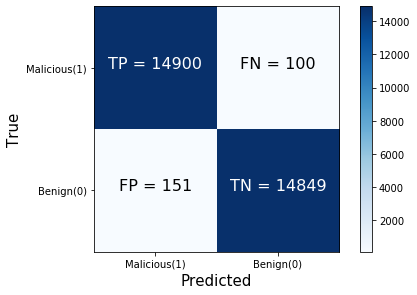

In [29]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


confusion_matrix= confusion_matrix.reshape([2,2])

con_mat = np.zeros([2,2], dtype = np.int)
con_mat[0][0] = confusion_matrix[1][1]
con_mat[0][1] = confusion_matrix[1][0]
con_mat[1][0] = confusion_matrix[0][1]
con_mat[1][1] = confusion_matrix[0][0]

plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Blues)

plt.tight_layout()
plt.colorbar()
label=["Malicious(1)", "Benign(0)"] # 라벨값
tick_marks = np.arange(len(label)) 
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
# 표 안에 숫자 기입하는 방법
name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(2):
     for j in range(2):
        plt.text(j, i, str(name[i][j])+" = "+str(con_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black",
                 fontsize=16)
    
plt.show()